# Structured Output Prediction of Anti-Cancer Drug Activity

Anas Atmani, Benoît Choffin, Domitille Coulomb, Paul Roujansky

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse.csgraph import minimum_spanning_tree
import time
import seaborn as sns

### Data

**Input:**

- We consider 2305 distinct molecules. Each of them has several physico-chemical and geometric properties that enables to build similarities between all molecules through a kernel. We end up with the (2305x2305) Gram matrix of the Tanimoto kernel.

**Ouput:**

- We have a total of 59 cancer cell lines for which we would like to predict the effect of each molecule (active/inactive). This last information is provided in a (2305x59) "target" matrix.

- We also have external RNA-based data for each cancer cell line. By computing the (59x59) correlation matrix based on these features, we build a similarity graph between all cancer cell lines through a *maximum weight spanning tree* (MWST). As a quick note, the graph should not necesarrily be fully-connected which should considerably reduce computation time.

### Modelling

Two approaches:

- take into account the similarities between the cancer cell lines and make use of this "structure" (goal of the article) through a MMCRF algorithm.
- perform prediction indepently for each cancer cell line, through a standard classification algortihm such as SVM.

In [257]:
X = np.loadtxt('data/ncicancer_input_kernel.txt')

In [258]:
Y_reg = np.loadtxt('data/ncicancer_targets.txt')

In [4]:
X.shape

(2305, 2305)

In [56]:
Y_reg.shape

(2305, 59)

In [92]:
Y_class = np.ones(Y_reg.shape)

In [105]:
Y_reg.shape, Y_class.shape

((2305, 59), (2305, 59))

In [118]:
'''
We put the activity threshold at 60 (as per https://github.com/hongyusu/Molecular_Classification < Process Data < 10.)
in order to get our classification targets (+1 if active, -1 if inactive)
'''

for i in range(Y_reg.shape[0]):
    Y_class[i, np.where(Y_reg[i,:]<60)] = -1

In [119]:
'''
As all of the 2305 molecules is active for at least one cancer cell line, we check that our threshold holds,
as data are the same that the ones from the previous link - Kongyu Su's git
'''
np.all(np.any(np.array([Y_class[i,:]==1 for i in range(Y_class.shape[0])]), 1))

True

In [255]:
np.savetxt('data/ncicancer_bin_targets.txt', Y_class)

# First approach: SVM

In [121]:
from sklearn.svm import SVC

In [256]:
X = np.loadtxt('data/ncicancer_input_kernel.txt')
Y_class = np.genfromtxt('data/ncicancer_bin_targets.txt')

In [166]:
'''
We instanciate one model for every cancer cell line (59 in total)
We fix C (the SVM hyperparameter) arbitrarily at 100 as per the original article (seems like a kind of optimal value).
'''
models = [SVC(C=100, kernel='precomputed') for i in range(Y_reg.shape[1])]

In [167]:
'''
We train the models independently for each cancer cell line on the full dataset (i.e. no cross val), as per the article.
'''
[model.fit(X, Y_class[:,i]) for i, model in enumerate(models)];

In [180]:
Y_pred = np.array([model.predict(X) for model in models]).T

In [181]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [182]:
accuracies = np.array([accuracy_score(Y_pred[:,i], Y_class[:,i]) for i in range(Y_reg.shape[1])])

In [195]:
np.mean(accuracies)*100

99.219824258244799

In [204]:
print("Accuracy")
print("---------------------------------------")
print("Average : \t \t %.2f%%" %(np.mean(accuracies)*100))
print("Standard deviation : \t %.2f%%" %(np.std(accuracies*100)))

Accuracy
---------------------------------------
Average : 	 	 99.22%
Standard deviation : 	 0.13%


In [205]:
''' Idea : do cross validation in order not to overfit and to optimize C '''

from sklearn.model_selection import train_test_split

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

# Second approach: MMCRF

In [207]:
ncicancer_activities = np.genfromtxt('data/external/ncicancer_activities.txt')
ncicancer_aids = np.genfromtxt('data/external/ncicancer_aids.txt')
ncicancer_features = np.genfromtxt('data/external/ncicancer_features.txt')
ncicancer_targets = np.genfromtxt('data/external/ncicancer_targets.txt')
ncicancer_aid2name = np.genfromtxt('data/external/id2aid2name.txt', dtype="i8,i8,S15")
'''
ncicancer_features: in case we want to recompute the Tanimoto kernel
'''

'\nncicancer_features: in case we want to recompute the Tanimoto kernel\n'

In [208]:
type(ncicancer_activities), type(ncicancer_aids), type(ncicancer_features), type(ncicancer_targets), type(ncicancer_aid2name)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [209]:
print(ncicancer_activities.shape)
print(ncicancer_aids.shape)
print(ncicancer_features.shape)
print(ncicancer_targets.shape)
print(ncicancer_aid2name.shape)

(43340, 73)
(73,)
(43340,)
(43340, 73)
(60,)


In [210]:
'''
We try to map our internal data (Y) to the external data (ncicancer_...)
- Y is Florence's data
- ncicancer_activities is Hongyu Su's data
'''

Y = np.loadtxt('data/ncicancer_targets_ex0.txt')

In [211]:
Y.shape

(2305, 59)

In [212]:
Y.shape

(2305, 59)

In [213]:
single = list()

idx_Y = np.arange(Y.shape[0])

tmp = Y.copy()

max_m = 59

m = 0
l = 0

print("m \t matches \t runTime \t % matched/total")
print("--------------------------------------------------------")

while np.logical_and(m<=max_m, l<=Y.shape[0]):
    
    startTime = time.time()
    
    test = [[i, idx_Y[i], np.where(np.all(ncicancer_activities[:,:m]==tmp[i,:m], axis=1))] for i in range(tmp.shape[0])]
    idx = [(i, idx1, np.array(idx2)[0][0]) for i, idx1, idx2 in test if np.array(idx2).shape[1]==1]
    if idx!=[]:
        single.append(idx)
        output = [i for i, idx1, idx2 in idx]
        tmp = np.delete(tmp, np.array(output), axis=0)
        idx_Y = np.delete(idx_Y, np.array(output))

    m += 1
    l += len(idx)
    
    runTime = time.time() - startTime
    
    if len(idx)>0:
        print("%d \t %d \t\t %d s \t\t %d/%d" %(m, len(idx), runTime, l, Y.shape[0]))
    
print("Complete : %d matches - %d remaining" %(l, tmp.shape[0]))

m 	 matches 	 runTime 	 % matched/total
--------------------------------------------------------
2 	 5 		 2 s 		 5/2305
3 	 157 		 8 s 		 162/2305
4 	 790 		 7 s 		 952/2305
5 	 774 		 4 s 		 1726/2305
6 	 309 		 2 s 		 2035/2305
7 	 138 		 1 s 		 2173/2305
8 	 41 		 0 s 		 2214/2305
9 	 12 		 0 s 		 2226/2305
10 	 20 		 0 s 		 2246/2305
11 	 6 		 0 s 		 2252/2305
12 	 4 		 0 s 		 2256/2305
13 	 6 		 0 s 		 2262/2305
14 	 2 		 0 s 		 2264/2305
16 	 1 		 0 s 		 2265/2305
17 	 2 		 0 s 		 2267/2305
18 	 1 		 0 s 		 2268/2305
19 	 4 		 0 s 		 2272/2305
20 	 2 		 0 s 		 2274/2305
21 	 2 		 0 s 		 2276/2305
22 	 1 		 0 s 		 2277/2305
23 	 1 		 0 s 		 2278/2305
24 	 1 		 0 s 		 2279/2305
25 	 5 		 0 s 		 2284/2305
30 	 1 		 0 s 		 2285/2305
31 	 2 		 0 s 		 2287/2305
34 	 2 		 0 s 		 2289/2305
39 	 1 		 0 s 		 2290/2305
44 	 3 		 0 s 		 2293/2305
48 	 1 		 0 s 		 2294/2305
49 	 3 		 0 s 		 2297/2305
50 	 3 		 0 s 		 2300/2305
53 	 2 		 0 s 		 2302/2305
55 	 1 		 0 s 		 2303/2305
56 	 1 		 0 

In [214]:
singles = np.vstack(single)[:,1:]

In [215]:
singles.shape

(2304, 2)

In [216]:
'''
Pairs of : (molecule index in "Y", molecule index in "ncicancer_activities")
where :
- dummy index
- Y is Florence's data
- ncicancer_activities is Hongyu Su's data

Comment:
One molecule is unmatched (in vector tmp), we remove it

'''
singles

array([[1733, 2530],
       [1734, 2531],
       [1735, 2532],
       ..., 
       [1866,  496],
       [  31, 1468],
       [ 100, 2398]], dtype=int64)

In [218]:
''' We look for potential doublons '''
if not np.logical_and(np.unique(singles[:,0]).shape==2304, np.unique(singles[:,1]).shape==2304):
    print("All good.")
else:
    print("Warning: doublons!")

All good.


In [219]:
singles

array([[1733, 2530],
       [1734, 2531],
       [1735, 2532],
       ..., 
       [1866,  496],
       [  31, 1468],
       [ 100, 2398]], dtype=int64)

In [220]:
'''
We take the first 59 cancer cell lines from the external data,
as we assume that the cell lines are in order (they should be fortunately).
'''
Y.shape, ncicancer_aid2name.shape

((2305, 59), (60,))

In [221]:
ncicancer_aid2name = ncicancer_aid2name[:59]

In [222]:
ncicancer_aid2name

array([( 1,   1, b'LC:NCI_H23'), ( 2,   3, b'LC:NCI_H226'),
       ( 3,   5, b'LC:NCI_H322M'), ( 4,   7, b'LC:NCI_H460'),
       ( 5,   9, b'LC:HOP_62'), ( 6,  13, b'LC:HOP_92'),
       ( 7,  15, b'LC:NCI_H522'), ( 8,  19, b'LC:A549'),
       ( 9,  21, b'LC:EKVX'), (10,  23, b'ME:LOXIMVI'),
       (11,  25, b'ME:M14'), (12,  29, b'ME:MALME_3M'),
       (13,  31, b'ME:UACC_62'), (14,  33, b'ME:UACC_257'),
       (15,  35, b'ME:SK_MEL_2'), (16,  37, b'ME:SK_MEL_5'),
       (17,  39, b'ME:SK_MEL_28'), (18,  41, b'PR:PC_3'),
       (19,  43, b'PR:DU_145'), (20,  45, b'CNS:SF_268'),
       (21,  47, b'CNS:SF_295'), (22,  49, b'CNS:SF_539'),
       (23,  53, b'CNS:SNB_19'), (24,  55, b'CNS:SNB_75'),
       (25,  59, b'CNS:U251'), (26,  65, b'CO:HT29'),
       (27,  67, b'CO:COLO205'), (28,  71, b'CO:HCT_15'),
       (29,  73, b'CO:KM12'), (30,  77, b'CO:HCC_2998'),
       (31,  79, b'CO:HCT_116'), (32,  81, b'CO:SW_620'),
       (33,  83, b'BR:MCF7'), (34,  85, b'ME:MDA_MB_435'),
       (35,

In [223]:
cancerCL_names = [name.decode('UTF-8') for i,j,name in ncicancer_aid2name]

In [224]:
'''
List of cancer cell lines in order
'''
cancerCL_names

['LC:NCI_H23',
 'LC:NCI_H226',
 'LC:NCI_H322M',
 'LC:NCI_H460',
 'LC:HOP_62',
 'LC:HOP_92',
 'LC:NCI_H522',
 'LC:A549',
 'LC:EKVX',
 'ME:LOXIMVI',
 'ME:M14',
 'ME:MALME_3M',
 'ME:UACC_62',
 'ME:UACC_257',
 'ME:SK_MEL_2',
 'ME:SK_MEL_5',
 'ME:SK_MEL_28',
 'PR:PC_3',
 'PR:DU_145',
 'CNS:SF_268',
 'CNS:SF_295',
 'CNS:SF_539',
 'CNS:SNB_19',
 'CNS:SNB_75',
 'CNS:U251',
 'CO:HT29',
 'CO:COLO205',
 'CO:HCT_15',
 'CO:KM12',
 'CO:HCC_2998',
 'CO:HCT_116',
 'CO:SW_620',
 'BR:MCF7',
 'ME:MDA_MB_435',
 'ME:MDA_N',
 'BR:BT_549',
 'BR:T47D',
 'OV:NCI_ADR_RES',
 'BR:MDA_MB_231',
 'BR:HS578T',
 'OV:OVCAR_3',
 'OV:IGROV1',
 'OV:SK_OV_3',
 'OV:OVCAR_4',
 'OV:OVCAR_5',
 'OV:OVCAR_8',
 'LE:RPMI_8226',
 'LE:SR',
 'LE:CCRF_CEM',
 'LE:K_562',
 'LE:MOLT_4',
 'LE:HL_60',
 'RE:A498',
 'RE:CAKI_1',
 'RE:RXF_393',
 'RE:786_0',
 'RE:ACHN',
 'RE:TK_10',
 'RE:UO_31']

In [225]:
cancerCL_RNA = np.genfromtxt('data/external/cancerCL_RNA.csv', delimiter=';', skip_header=1)

In [226]:
cancerCL_RNA.shape

(457, 60)

In [227]:
with open('data/external/cancerCL_names.txt') as f:
    cancerCL_names_ext = f.readlines()
cancerCL_names_ext = [x.strip() for x in cancerCL_names_ext]

In [228]:
'''
One more cancer cell line in the RNA dataset
'''
len(cancerCL_names_ext), len(cancerCL_names)

(60, 59)

In [229]:
matches = np.array([(i,j) for i in range(len(cancerCL_names)) for j in range(len(cancerCL_names_ext)) if cancerCL_names[i]==cancerCL_names_ext[j]])

In [230]:
'''
matches
'''
matches.shape

(59, 2)

In [231]:
RNA_matrix = cancerCL_RNA[:,matches[:,1]]

In [232]:
RNA_matrix.shape

(457, 59)

In [233]:
RNA_matrix

array([[  5.72,   8.38,  12.36, ...,   9.28,   9.94,  10.54],
       [  7.45,   8.04,  12.32, ...,   8.55,  10.11,  10.63],
       [  2.3 ,   9.15,   8.54, ...,   6.69,   7.94,   8.03],
       ..., 
       [  5.33,   6.46,   5.87, ...,   2.3 ,   2.3 ,   2.3 ],
       [  6.29,   7.45,   7.35, ...,   2.3 ,   5.58,   9.12],
       [  2.3 ,   6.1 ,   5.81, ...,   2.3 ,   2.3 ,   2.3 ]])

In [234]:
RNA_correl_matrix = np.corrcoef(RNA_matrix, rowvar=0)

In [240]:
RNA_correl_matrix.shape

(59, 59)

In [241]:
RNA_correl_matrix

array([[ 1.        ,  0.82826212,  0.86611257, ...,  0.8652913 ,
         0.8910083 ,  0.87741896],
       [ 0.82826212,  1.        ,  0.78416656, ...,  0.8054095 ,
         0.83887939,  0.80604146],
       [ 0.86611257,  0.78416656,  1.        , ...,  0.85313056,
         0.89428307,  0.88120767],
       ..., 
       [ 0.8652913 ,  0.8054095 ,  0.85313056, ...,  1.        ,
         0.9258626 ,  0.91469322],
       [ 0.8910083 ,  0.83887939,  0.89428307, ...,  0.9258626 ,
         1.        ,  0.94502691],
       [ 0.87741896,  0.80604146,  0.88120767, ...,  0.91469322,
         0.94502691,  1.        ]])

In [250]:
np.savetxt('data/ncicancer_cancerCL_corr.txt', RNA_correl_matrix)

### Maximum spanning tree

In [236]:
import networkx as nx

In [49]:
G = nx.from_numpy_matrix(RNA_correl_matrix)

In [50]:
nx.maximum_spanning_tree(G)

AttributeError: module 'networkx' has no attribute 'maximum_spanning_tree'

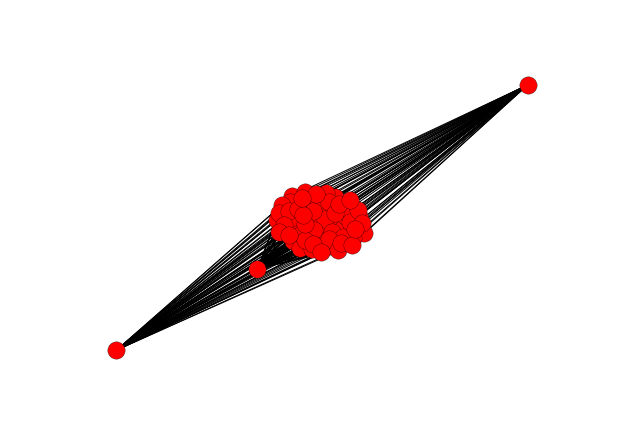

In [249]:
nx.draw(G)

In [ ]:
help(nx)